In [255]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import time 
import tqdm
import math
import xarray as xr
from scipy.special import softmax
import torch
%matplotlib inline
from torch.autograd import Variable


In [256]:
if torch.__version__ != '1.10.0':
    print('You need to upgrade PyTorch before running this code.')

else:
    print('Ready to go!')

Ready to go!


# Model definition 

In [324]:
class BinaryTS:
    
    def __init__(self,d=10,T=10,N=10, true_A=None, true_B=None, true_sigma=None,R=10000):
        
        """
        Instanciates the binaryTS model. 
        
        Arguments: 
        
        - d: dimension of the model. 
        - A: (d,d) matrix that controls the dynamics related to the observed state. 
        - B: (d,d) matrix that controls the dynamics related to the latent state. 
        - sigma: (d,d) positive definite matrix that controls the variance of the noise. 
        - R: number of MCMC samples for expectation approximations used in VEM. 
        
        By default, the BinaryTS model is instanciated with random matrices A, B and sigma. You can provide your 
        own, but B should have all its eigenvalues of module less than 1 in order to enforce stability of the model
        (see companion paper for further information). 
        
        """
        
        self.d = d
        self.T = T
        self.N = N
        
        if true_A is None:
            self.true_A = 0.8*np.identity(d) 
        else: 
            self.true_A = true_A
            
        if true_B is None:     
            random_eig = np.random.uniform(low=-0.7,high=0.7,size=d) 
            self.true_B = np.diag(random_eig) 
        else:
            self.true_B = true_B
        
        if true_sigma is None:
            random_matrix = np.random.randn(d,d)
            self.true_sigma = np.dot(random_matrix,random_matrix.T)
            
        else:
            self.true_sigma = true_sigma
        
        self.true_sigma_inv = np.linalg.inv(self.true_sigma)
        self.data = None
        self.R = R
        
        
        
    ### Util functions###
    
    def sample(self,N=100,T=100,fixdata=True):
        
        """
        Samples N samles over T timesteps from the DGP. If fixdata is set to True, sampled x data is saved in 
        an attribute called self.data, along with (N,T) used for sampling in self.N and self.T. 
        """
        
        x_data = np.zeros((N,self.d,T+1))
        z_data = np.zeros((N,self.d,T+1))
        p_data = np.zeros((N,self.d,T+1))
        
        self.x0 = np.random.randint(0,2,size=(self.d,N))
        self.z0 = np.random.randn(self.d,N)
        
        x = self.x0
        z = self.z0
        
        x_data[:,:,0] = self.x0.T
        z_data[:,:,0] = self.z0.T
        p_data[:,:,0] = 1/2*np.ones((N,self.d))
        
        for t in np.arange(1,T+1): 
            z = self.true_A@x + self.true_B@z + np.random.multivariate_normal(mean=np.zeros(self.d),cov=self.true_sigma,size=N).T
            p = softmax(z,axis=0)
            x = np.random.binomial(1,p,size=(self.d,N))
            x_data[:,:,t] = x.T
            z_data[:,:,t] = z.T
            p_data[:,:,t] = p.T
            
        if fixdata: 
            self.data = x_data
            self.N = N
            self.T = T
        
        return x_data,z_data,p_data
    
    def snapshot(self,N,T,x_data=None,z_data=None,p_data=None,pltdim = 3,plttime=500,save=False): 
        
        """
        Generates and plots some data from the data generating process. This method displayes three components 
        of the DGP for every dimension: 
        - the observed, 0-1 valued process
        - the latent state
        - the probability associated to the current latent state obtained through softmaxification. 
        
        Arguments:
        
        - N: number of individuals (for plotting, one is choosen at random).
        - T: number of timesteps over which data is generated. 
        - x_data, z_data, p_data: allows to pass previously generate data for plotting (instead of 
        generating new observations).
        - pltdim: number of dimensions plotted. 
        - plttime: number of timesteps plotted. 
        - save: if set to True, a .pdf of the generated image is saved. 
        """
        
        if x_data is None and z_data is None and p_data is None: 
            x_data,z_data,p_data = self.sample(N=N,T=T,fixdata=False)
            
        plttime = np.minimum(T,plttime)
        pltdim = np.minimum(pltdim,self.d)
        random_ind = np.random.randint(0,N)
        
        sns.set_context('talk')
        sns.set_style('white')
            
        f,ax=plt.subplots(pltdim,3,figsize=(pltdim*30,pltdim*13))
        f.suptitle('Observed state, hidden state and transition probability by dimension of the model',fontsize=65,fontweight='heavy')
                
        for i in np.arange(pltdim):
        
            ax[i,0].plot(x_data[random_ind,i,:plttime],c='orange')
            ax[i,1].plot(z_data[random_ind,i,:plttime],c='red')
            ax[i,2].plot(p_data[random_ind,i,:plttime],c='green')
            
                        
            ax[i,0].set_yticks([0,1])
            
            for a in ['left','bottom']:
            
                ax[i,0].spines[a].set_linewidth(2.5)
                ax[i,1].spines[a].set_linewidth(2.5)
                ax[i,2].spines[a].set_linewidth(2.5)
            
            for j in [0,1,2]:
                ax[i,j].spines["right"].set_visible(False)
                ax[i,j].spines["top"].set_visible(False)
                ax[i,j].tick_params(axis='both', labelsize=50)
        
        
        ax[pltdim-1,0].set_xlabel('Observed state',fontsize=55,fontweight='bold',labelpad=20)
        ax[pltdim-1,1].set_xlabel('Hidden state',fontsize=55,fontweight='bold',labelpad=20)
        ax[pltdim-1,2].set_xlabel('Transition probability',fontsize=55,fontweight='bold',labelpad=20)
        
        plt.tight_layout()
        
        if save: 
            
            plt.savefig('snapshot.pdf')
    
    
    ### Functions for VEM ###
    
    def variance_initialization(self): 
        
        """
        Returns a random initialization for the diagonal and subdiagonal elements of the B matrix that
        parametrizes the variational density, as a (self.d,2*self.T+1)-tensor. For every line d, the first
        self.T+1 elements are the diagonal elements of the Cholesky decomposition of the precision matrix
        of dimension d, while the next self.T elements are the subdiagonal elements. 
        
        The precision matrices (there are d of them) can be obtained by calling 
        self.compute_precision(self.form_B(self.variance_initialization())).
        
        """
        
        #return torch.rand(self.d,2*self.T+1)
        return torch.ones(self.d,2*self.T+1)
    
    
    def form_B(self,nu_omega): 
        
        """
        Given a (d,2*T+1)-tensor as input, forms a (d,T+1,T+1)-tensor structured as follows: 
            - for a given d, the diagonal elements of the (T+1,T+1) subtensor are the first T+1 elements 
            of nu_omega[d,:].
            - for a given d, the subdiagonal elements of the (T+1,T+1) subtensor are the last T elements of 
            nu_omega[d,:].
        """
        
        nu = nu_omega[:,:self.T+1]
        omega = nu_omega[:,self.T+1:]
        
        B=torch.diag_embed(nu)+torch.diag_embed(omega,offset=1)
        
        return B

    
    def compute_precision(self,B): 
        
        """
        Given a (d,self.T+1,self.T+1)-tensor of Cholesky decompositions that parametrizes the 
        variational density, returns the un-decomposed matrix.   
        
        Arguments:
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.
        """
        
        return torch.transpose(B,dim0=1,dim1=2)@B
    
    def compute_covmat(self,B): 
        
        """
        Computes the (self.d,self.T+1,self.T+1)-variance-covariance tensor, starting from 
        a (self.d,self.T+1,self.T+1)-Cholesky decomposition-tensor, in a differentiable way.
        
        Arguments: 
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.   
        """
        
        return torch.linalg.inv(torch.transpose(B,dim0=1,dim1=2)@B)
    
    def check_data(self):
        
        """
        Util function to check wether self.data is empty.
        """
        
        if self.data is None: 
            raise ValueError('self.data is empty. Use self.sample(args,fixdata=True) to sample some data first.')
            
    def full_log_expectation(self): 
    
        """
        For every t in [1,self.T], approximates the expectation of 
        
                        $\log \sum_p \exp[\Omega_p^{(t,t)}X+\mu_{p,t}]$
                        
        through MCMC-approximation with self.R samples, where 
            - Omega_i^{(t,t)} is the (t,t)-th element of the variance-covariance matrix of the d-th dimension 
            of the variational density.
            - mu_{p,t} is the (p,t)-th element of the expectation matrix of the variational density. 
            
        Returns a (self.T+1)-tensor. 

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
    
        sigma_inv = torch.linalg.inv(self.sigma)

        precision_matrix = self.compute_precision(self.form_B(self.var_approx))
        covariance_matrix = self.compute_covmat(precision_matrix[:,1:,1:])
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        draw = torch.randn(self.R,self.d,self.T)
        transformed_draw = diagonal_terms*draw + self.mu_approx[:,1:]
        logsumexp_draw = torch.logsumexp(transformed_draw,dim=1)
        
        if torch.any(torch.isnan(logsumexp_draw)):
            print('Nans in full log approx')
            
        vector_approx = logsumexp_draw.mean()
        sum_approx = vector_approx.sum()
        
        return sum_approx 
    
    def partial_log_expectation(self):
    
        """
        For every i in [1,self.d] and every t in [0,self.T], approximates the expectation of 
        
                        $\log \sum_{p \neq i} \exp[\Omega_{p}^{(t,t)}X+\mu_{p,t}]$
                        
        through MCMC-approximation with self.R samples, where 
            - Omega_i^{(t,t)} is the (t,t)-th element of the variance-covariance matrix of the d-th dimension 
            of the variational density.
            - mu_{p,t} is the (p,t)-th element of the expectation matrix of the variational density. 
            
        Returns a (self.d,self.T+1)-tensor. 

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R

        sigma_inv = torch.linalg.inv(self.sigma)
        
        precision_matrix = self.compute_precision(self.form_B(self.var_approx))
        covariance_matrix = self.compute_covmat(precision_matrix[:,1:,1:])
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        results = torch.zeros(self.d,self.T)
        
        for i in np.arange(d): 
            
            draw = torch.randn(self.R,self.d,self.T)
            mask = torch.ones(d)
            mask[i] = 0
            mask = mask.long()
            masked_diagonal_terms = diagonal_terms[mask,:]
            masked_mu_approx = self.mu_approx[mask,1:]
            transformed_draw = masked_diagonal_terms*draw + masked_mu_approx
            logsumexp_draw = torch.logsumexp(transformed_draw,dim=1)
            vector_approx = logsumexp_draw.mean()
            results[i,:] = vector_approx

        if torch.any(torch.isnan(results)):
            print('Nans in partial log approx')
        
        return results
    
    def compute_bilinear_term(self):
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        batchsize=self.batchsize
        batch=self.batch
       
        sigma_inv = torch.linalg.inv(self.sigma)
        
        
        data = torch.from_numpy(self.data).type(torch.FloatTensor)
                        
        result = -batchsize/2*torch.trace(self.mu_approx[:,1:].T@sigma_inv@self.mu_approx[:,1:])
        
        result += batchsize*torch.trace(self.mu_approx[:,1:].T@sigma_inv@self.B@self.mu_approx[:,:T])
        
        result += -batchsize/2*torch.trace(self.mu_approx[:,:T].T@(self.B.T)@sigma_inv@self.B@self.mu_approx[:,:T])
        
        result += -1/2*sum([torch.trace((self.A@data[i,:,:T]).T@sigma_inv@(self.A@data[i,:,:T])) for i in batch])
                
        result += -sum([torch.trace((self.A@data[i,:,:T]).T@sigma_inv@(self.B@self.mu_approx[:,:T]-self.mu_approx[:,1:])) for i in batch])
        
        return result   
        
    def compute_elbo(self):
        
        """
        Returns the Evidence Lower Bound (ELBO) of the model, normalized by 1/(N*T*d), as a pytorch tensor.
        """
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        self.construct_mu()
        self.construct_var()
        
        batchsize = self.batchsize
        self.batch = np.random.choice(N,batchsize,replace=False)
        batch = self.batch
                
        sigma_inv = torch.linalg.inv(self.sigma)
        data = torch.from_numpy(self.data).type(torch.FloatTensor)
        var_approx = self.form_B(self.var_approx)
        covariance_matrix = self.compute_covmat(var_approx)
        
        variational_entropy = 2*batchsize*sum([sum(torch.log(torch.diag(var_approx[i,:,:]))) for i in np.arange(d)])

        entropy = (T*batchsize/2)*torch.logdet(sigma_inv)
        
        if torch.isnan(entropy):
            print('entropy is nan')
            print(self.sigma)
                
        #Compute bilinear term
        
        bilinear_term = self.compute_bilinear_term()
        
        #Compute big sum with approximated expectations
        
        mu_x_prod = sum([torch.trace(data[i,:,1:].T@self.mu_approx[:,1:]) for i in batch])
        
        full_log_approx = self.full_log_expectation()
        
        big_sum = mu_x_prod - batchsize*d*full_log_approx
                
        partial_log_approx = self.partial_log_expectation()
        
        big_sum += -(data[batch,:,1:]*partial_log_approx).sum() + batchsize*(partial_log_approx.sum())
        
        #Compute trace term
        
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        sub_diagonal_terms = torch.diagonal(covariance_matrix,offset=1,dim1=1,dim2=2)
        
        trace_term = (torch.diagonal(sigma_inv)*(diagonal_terms[:,1:].sum(axis=1))).sum()
        
        trace_term += (torch.diagonal(self.B.T@sigma_inv@self.B)*(diagonal_terms[:,:T].sum(axis=1))).sum()
        
        trace_term += -(torch.diagonal(sigma_inv@self.B)*(sub_diagonal_terms.sum(axis=1))).sum()
        
        trace_term = -1/2*batchsize*trace_term 
        
        #Put all terms together
            
        elbo_value = variational_entropy + entropy + bilinear_term + big_sum + trace_term 

        return (1/(batchsize*T*d))*elbo_value
    
    def define_tracks(self):
        
        """
        Util function that defines empty tensors for saving training results. 
        
        """
        
        self.elbo_track = torch.zeros(1)
        
        self.predicted_likelihood_track = torch.zeros(1)
        
        self.A_grad_track = torch.zeros(1)
        self.B_grad_track = torch.zeros(1)
        self.sigma_grad_track = torch.zeros(1)
        self.mu_approx_grad_track = torch.zeros(1)
        self.var_approx_grad_track = torch.zeros(1)
        
        self.mu_approx_track = torch.zeros(self.d,self.T+1)
        self.var_approx_track = torch.zeros(self.d,self.T+1,self.T+1)
        
        self.A_track = torch.zeros(self.d,self.d)
        self.A_error_track = torch.zeros(1)
        
        self.B_track = torch.zeros(self.d,self.d)
        self.B_error_track = torch.zeros(1)
        
        self.sigma_track = torch.zeros(self.d,self.d)
        self.sigma_error_track = torch.zeros(1)
    
    def save_results(self,save_grad=True): 
        
        """
        Util function that saves current values of
            - the ELBO (Evidence Lower Bound), which is the objective function that is maximized ;
            - mu_approx, a (d,T+1)-tensor that encodes the variational mean parameters ;
            - var_approx, a (d,T+1,T+1)-tensor that encodes the variational variance parameters ;
        
        and the current estimated values of 
            - A, B and sigma, three (d,d)-tensors that govern the dynamics of the latent space. 
            
        This function also saves the difference in Froebenius norm between these estimates and the 
        real parameters of the model. 
        
        Before calling this function, you need to define 
            - self.elbo_track
            - self.mu_approx_track
            - self.var_approx_track
            - self.A_track
            - self.A_error_track
            - self.B_track
            - self.B_error_track
            - self.sigma_track
            - self.sigma_error_track
            
        as empty tensors. This can be done by calling the util function self.define_tracks().  
        
        torch.no_grad() ensures that the saving of results does not result in unecessary gradient saving.
        
        """
        
        with torch.no_grad():
            
            #Save ELBO
            
            self.elbo_track = torch.cat((self.elbo_track,torch.tensor([-self.elbo])))
            
            #Save predicted likelihood
            
            self.predicted_likelihood_track = torch.cat((self.predicted_likelihood_track,torch.tensor([self.predictive_likelihood(N=100,T=50)])))
            
            #Save gradients
            
            self.A_grad_track = torch.cat((self.A_grad_track, torch.tensor([torch.linalg.norm(self.A.grad)])))
            self.B_grad_track = torch.cat((self.B_grad_track, torch.tensor([torch.linalg.norm(self.B.grad)])))
            self.sigma_grad_track = torch.cat((self.sigma_grad_track, torch.tensor([torch.linalg.norm(self.sigma.grad)])))
            mu_grad = (sum([(self.mu_dic[key]["variable"].grad)**2 for key in self.mu_dic.keys()]))**(1/2)
            self.mu_approx_grad_track = torch.cat((self.mu_approx_grad_track, torch.tensor([mu_grad])))
            var_grad = (sum([(self.var_dic[key]["variable"].grad)**2 for key in self.var_dic.keys()]))**(1/2)
            self.var_approx_grad_track = torch.cat((self.var_approx_grad_track, torch.tensor([var_grad])))
            
            #Save mu_approx results
            
            self.mu_approx_track = torch.cat((self.mu_approx_track,self.mu_approx))
            
            #Save var_approx results
            
            cholesky_dec = self.form_B(self.var_approx)
            precision_matrix = self.compute_precision(cholesky_dec)
            self.var_approx_track = torch.cat((self.var_approx_track,precision_matrix))
            
            #Save A results
            
            self.A_track = torch.cat((self.A_track,self.A))
            A_error = torch.tensor([torch.norm(torch.tensor(self.true_A)-self.A)])
            self.A_error_track = torch.cat((self.A_error_track,A_error))
            
            #Save B results
            
            self.B_track = torch.cat((self.B_track,self.B))
            B_error = torch.tensor([torch.norm(torch.tensor(self.true_B)-self.B)])
            self.B_error_track = torch.cat((self.B_error_track,B_error))
            
            #Save sigma results
            
            self.sigma_track = torch.cat((self.sigma_track,self.sigma))
            sigma_error = torch.tensor([torch.norm(torch.tensor(self.true_sigma)-self.sigma)])
            self.sigma_error_track = torch.cat((self.sigma_error_track,sigma_error))
    
                
    def predictive_likelihood(self,N,T): 
        
        """
        Util function that computes the predicted likelihood (see companion paper).
        """
        
        with torch.no_grad():
            
            x_test,z_test,_ = self.test_data
            A = self.A.detach().numpy()
            B = self.B.detach().numpy()
            sigma = self.sigma.detach().numpy()

            summed_likelihood = 0

            for t in np.arange(1,self.testT): 
                z = np.matmul(A,x_test[:,:,t-1].T) + np.matmul(B,z_test[:,:,t-1].T) + np.random.multivariate_normal(mean=np.zeros(self.d),cov=sigma,size=self.testN).T
                p = np.log(softmax(z,axis=0))
                likelihood = x_test[:,:,t].T*p + (1-x_test[:,:,t].T*(1-p))
                summed_likelihood += likelihood.sum()
            
        return (1/(N*T))*summed_likelihood
    
    def true_predictive_likelihood(self,N,T): 
        
        """
        Util function that computes the predicted likelihood (see companion paper).
        """
        
        with torch.no_grad():
            
            x_test,z_test,_ = self.test_data
            A = true_A
            B = true_B
            sigma = true_sigma

            summed_likelihood = 0

            for t in np.arange(1,self.testT): 
                z = np.matmul(A,x_test[:,:,t-1].T) + np.matmul(B,z_test[:,:,t-1].T) + np.random.multivariate_normal(mean=np.zeros(self.d),cov=sigma,size=self.testN).T
                p = np.log(softmax(z,axis=0))
                likelihood = x_test[:,:,t].T*p + (1-x_test[:,:,t].T*(1-p))
                summed_likelihood += likelihood.sum()
            
        return (1/(N*T))*summed_likelihood
                
        
    def construct_mu(self):
        
        """
        Forms a (d,T+1)-tensor representing mu, the variational mean parameter, from the mu_dic dictionnary. 
        This is necessary to implement coordinate-ascent in Pytorch. 
        
        """
        
        
        self.mu_approx = torch.zeros((self.T+1)*self.d)
        
        for j in np.arange(0,(self.T+1)*self.d):
            variable = self.mu_dic[str(j)]['variable']
            self.mu_approx[j] = variable
            
        self.mu_approx = self.mu_approx.reshape(d,self.T+1)
        
    def construct_var(self):
        
        """
        Forms a (d,2*T+1)-tensor representing the set of lambda_i's, the variational variance parameters,
        from the var_dic dictionnary. This is necessary to implement coordinate-ascent in Pytorch. 
        
        """
        
        self.var_approx = torch.zeros(self.d*(2*self.T+1))
        
        for j in np.arange(0,(2*self.T+1)*self.d):
            variable = self.var_dic[str(j)]['variable']
            self.var_approx[j] = variable
            
        self.var_approx = self.var_approx.reshape(d,2*self.T+1)
        
    def cavi_optimizers(self,latent_lrs,mu_lr,var_lr): 
        
        """
        Util function that creates three dictionnaries that store variables, optimizers and learning rates for
        coordinate-ascent optimization.
        Specifically, this method creates 
        
            - latent_dic, a dictionnary that contains self.A, self.B and self.sigma
            and their optimization parameters (Pytorch optimizer and learning rate);
            
            - mu_dic, a dictionnary that contains every variational mean parameter (there are (self.T+1)*d of them)
            coded as a variable with its own Pytorch optimizer and learning rate;
            
            - var_dic, a dictionnary that contains every variational variance parameter (there are (2*self.T+1)*d 
            of them) coded as a variable with its own Pytorch optimizer and learning rate.
        
        """
        
        self.latent_dic = {"A":{},"B":{},"sigma":{}}
        
        self.latent_dic["A"]['variable']= self.A
        self.latent_dic["B"]['variable']= self.B
        self.latent_dic["sigma"]['variable']= self.sigma

        for i,key in enumerate(self.latent_dic.keys()):

            self.latent_dic[key]["lr"] = latent_lrs[i]
            self.latent_dic[key]["optimizer"] =torch.optim.Adam([self.latent_dic[key]['variable']],lr=self.latent_dic[key]['lr'])

        self.mu_dic = {}

        for i,line in enumerate(self.mu_approx):
            for i_bis,coordinate in enumerate(line):
                key = str(i*(self.T+1)+i_bis)
                self.mu_dic[key] ={}
                self.mu_dic[key]['variable'] = coordinate
                
                self.mu_dic[key]['variable'].requires_grad = True
                self.mu_dic[key]['optimizer'] = torch.optim.Adam([self.mu_dic[key]['variable']],lr=mu_lr)
                
                
        self.construct_mu()

        self.var_dic = {}

        for i,line in enumerate(self.var_approx):
            for i_bis,coordinate in enumerate(line):
                    key = str(i_bis+i*(2*self.T+1))
                    self.var_dic[key] ={}
                    self.var_dic[key]['variable'] = coordinate
                    self.var_dic[key]['variable'].requires_grad = True
                    self.var_dic[key]['optimizer'] = torch.optim.Adam([self.var_dic[key]['variable']],lr=var_lr)
                    
        
        self.construct_var()


    def block_cavi(self,latent_lrs=[1e-2,1e-2,1e-4],mu_lr=1e-2,var_lr=1e-2,max_iter=100,its=2,batchsize=2): 
        
        """
        Optimization of the ELBO using a block-coordinate-ascent algorithm. 
        
        Arguments: 
            - latent_lrs (list): learning rates for resp. A, B and sigma;
            
            - mu_lr (scalar > 0): learning rate for the variational density mean parameters;
            
            - var_lr (scalar > 0): learning rate for the variational density variance parameters. 
        
        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        self.batchsize=batchsize
        
        self.sample(N=N,T=T)
        
        #Create test data
        self.testN = 50
        self.testT = 50
        
        self.test_data = self.sample(N=self.testN,T=self.testT,fixdata=False)
        
        self.true_pred_log = self.true_predictive_likelihood(N=self.testN,T=self.testT)
        
        #Parameters initialization
        
        sigma = 0.5*torch.eye(self.d,self.d)
        sigma.requires_grad=True
        self.sigma = sigma
        
        A = torch.ones(self.d,self.d) + torch.randn(self.d,self.d)
        A.requires_grad = True
        self.A = A
        
        B = 0.5*torch.ones(self.d,self.d)+torch.randn(self.d,self.d)
        B.requires_grad = True
        self.B = B
        
        data_mean = self.data.mean(axis=0)
        mu_approx = torch.from_numpy(data_mean)
        mu_approx = mu_approx.float()
        self.mu_approx = mu_approx
        
        var_approx = self.variance_initialization()
        self.var_approx = var_approx
            
        self.define_tracks()
        
        self.cavi_optimizers(latent_lrs,mu_lr,var_lr)
        
        n_params = 3 + (T+1)*d + d*(2*T+1)
        
        print('-----------------------------------------')
        print('---------------------------------')
        print('--------------------------')
        print('-------------------')  
        print('\n')
        print('Block-CAVI initialization...')
        print('\n')
        print('--------Dimensions of the model--------')
        print('T: ', T)
        print('d: ', d)
        print('N: ', N)
        print('\n')
        print('-------- Optimization parameters --------')
        print('Batchsize: ', self.batchsize)
        print('\n')
        print('Optimizer for A:', self.latent_dic['A']['optimizer'] )
        print('Optimizer for B:', self.latent_dic['B']['optimizer'] )
        print('Optimizer for sigma:', self.latent_dic['sigma']['optimizer'] )
        print('Optimizer for mu_approx:', self.mu_dic['0']['optimizer'] )
        print('Optimizer for var_approx:', self.var_dic['0']['optimizer'] )
        print('\n')
        print('-------------------') 
        print('--------------------------')
        print('---------------------------------')
        print('-----------------------------------------')
        print('\n')
        print('\n')
        print('-------- TRAINING STARTS --------')
        print('\n')
        print('\n')
        
        
        t1 = time.time()
        
        for t in np.arange(max_iter):
        
            random_order = np.random.permutation(np.arange(n_params))
            
            for j in random_order: 
                
                if j in [0,1,2]: 
                    
                    parameter = list(self.latent_dic.keys())[j]
                    optimizer = self.latent_dic[parameter]["optimizer"]
                    
                    for it in np.arange(its):
                        self.elbo = -self.compute_elbo()
                        self.elbo.backward(retain_graph=True)
                        optimizer.step()
                        optimizer.zero_grad()
                    
                if j in np.arange(3,(T+1)*d+3):
                    
                    j += - 3
                    parameter = list(self.mu_dic.keys())[j]
                    optimizer = self.mu_dic[parameter]["optimizer"]
                    for it in np.arange(its):
                        self.elbo = -self.compute_elbo()
                        self.elbo.backward(retain_graph=True)
                        optimizer.step()
                        optimizer.zero_grad()
                    
                if j >= (T+1)*d+3:
                    
                    j += -((self.T+1)*d+3)
                    parameter = list(self.var_dic.keys())[j]
                    optimizer = self.var_dic[parameter]["optimizer"]
                    
                    for it in np.arange(its):
                        self.elbo = -self.compute_elbo()
                        self.elbo.backward(retain_graph=True)
                        optimizer.step()
                        optimizer.zero_grad()
                    
            if t%10 == 0:
                print('---------- Iteration ', t, ' ---------- ')
                      
                print('Current ELBO value: ', -self.elbo)
                
                print('Difference w. average of last 10 value: ', -self.elbo - self.elbo_track[-10:].mean())
                
                print('Average of last 10 PL: ', self.predicted_likelihood_track[-10:].mean())
                      
            
            self.save_results()
            #print(self.predictive_likelihood(N=self.testN,T=self.testT))
            
        t2 = time.time()
        
        print('-------- TRAINING FINISHED IN ', t2-t1, ' SECONDS --------')

# Optimization tests

## Model specification

In [325]:
d = 2
T = 4
N = 500

In [326]:
true_A = np.identity(d) + np.random.randn(d,d)
true_B = np.diag(np.random.uniform(low=-0.8,high=0.8,size=d)) +1/10*np.array([[0,-1],[-1,0]])

#small_noise = 1/2*np.random.randn(1)
true_sigma = np.diag(np.random.uniform(low=1,high=4,size=d)) 

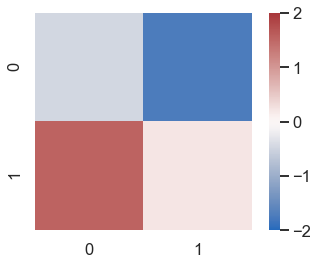

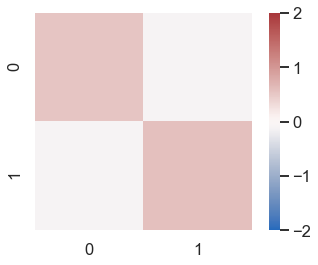

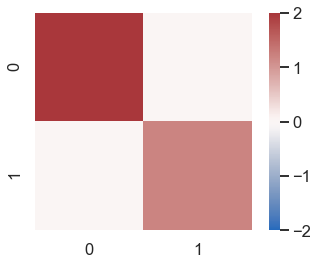

In [327]:
sns.heatmap(true_A,square=True,cmap='vlag',vmin=-2,vmax=2)
plt.show()
sns.heatmap(true_B,square=True,cmap='vlag',vmin=-2,vmax=2)
plt.show()
sns.heatmap(true_sigma,square=True,cmap='vlag',vmin=-2,vmax=2)
plt.show()

In [328]:
bints = BinaryTS(d=d,T=T,N=N,true_A = true_A,true_B=true_B,true_sigma = true_sigma)

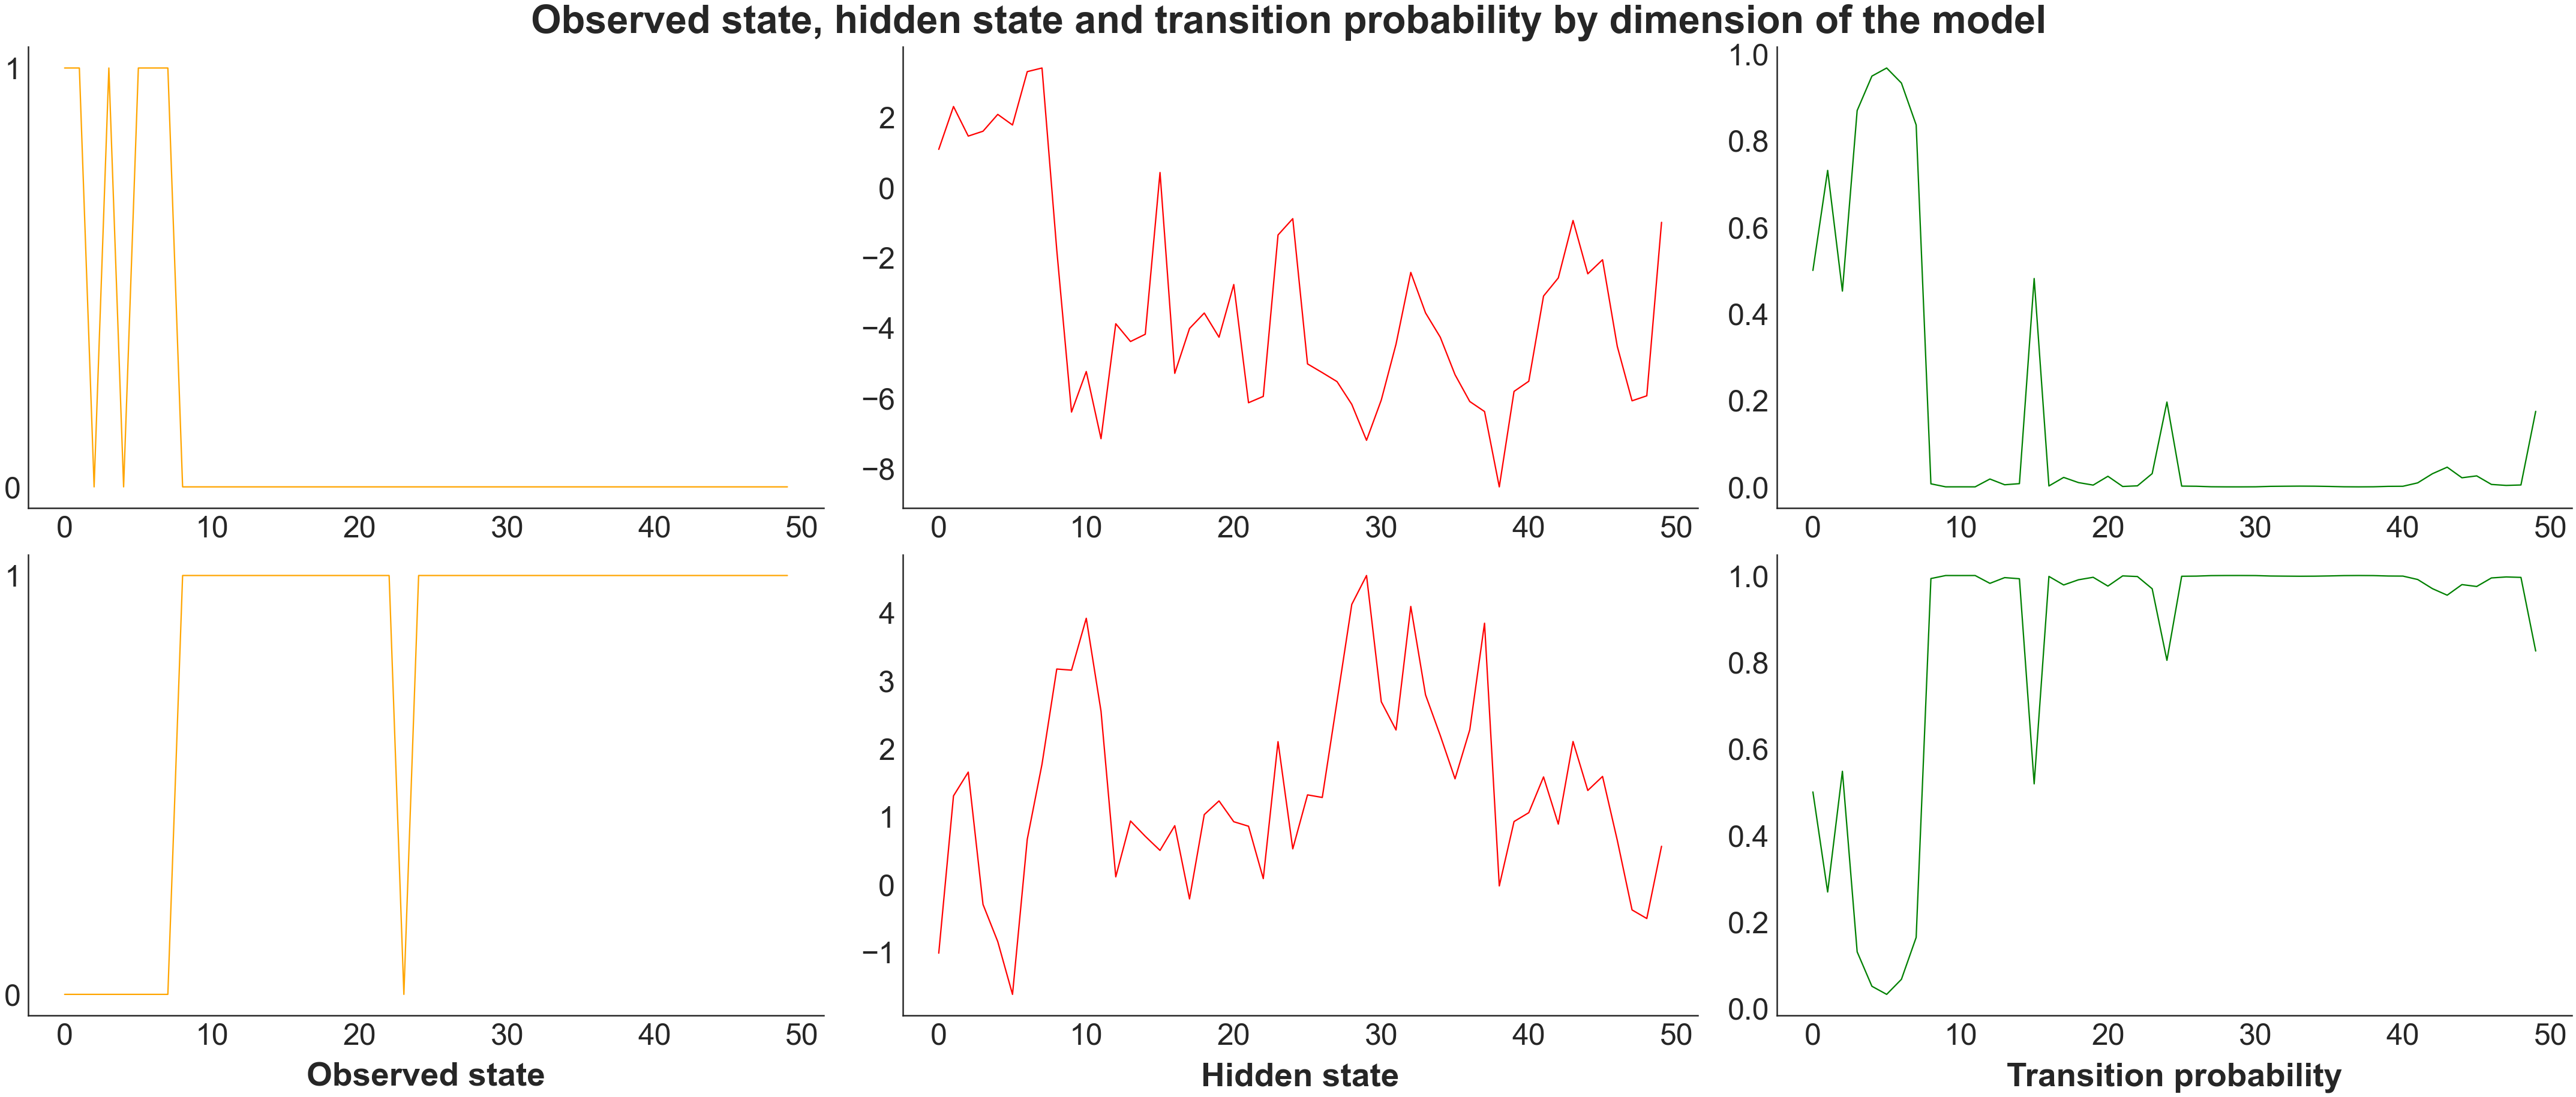

In [329]:
bints.snapshot(N=2,T=50)

## CAVI

This cell performs coordinate-wise gradient ascent, a standard method for maiximizing the ELBO in variational inference. 

In [403]:
bints.block_cavi(latent_lrs=[1e-1,1e-1,1e-3],mu_lr=1e-4,var_lr=1e-4,max_iter=500,its=1,batchsize=5)

-----------------------------------------
---------------------------------
--------------------------
-------------------


Block-CAVI initialization...


--------Dimensions of the model--------
T:  4
d:  2
N:  500


-------- Optimization parameters --------
Batchsize:  5


Optimizer for A: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)
Optimizer for B: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)
Optimizer for sigma: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Optimizer for mu_approx: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Optimizer for var_approx: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)


-------------------
---

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:529: RuntimeWarning: covariance is not positive-semidefinite.


---------- Iteration  10  ---------- 
Current ELBO value:  tensor(-1.8275, grad_fn=<NegBackward0>)
Difference w. average of last 10 value:  tensor(2.5285, grad_fn=<SubBackward0>)
Average of last 10 PL:  tensor(0.1615, dtype=torch.float64)
---------- Iteration  20  ---------- 
Current ELBO value:  tensor(-1.0899, grad_fn=<NegBackward0>)
Difference w. average of last 10 value:  tensor(0.1812, grad_fn=<SubBackward0>)
Average of last 10 PL:  tensor(-1.0337, dtype=torch.float64)
---------- Iteration  30  ---------- 
Current ELBO value:  tensor(-1.0676, grad_fn=<NegBackward0>)
Difference w. average of last 10 value:  tensor(0.0689, grad_fn=<SubBackward0>)
Average of last 10 PL:  tensor(-1.9317, dtype=torch.float64)
---------- Iteration  40  ---------- 
Current ELBO value:  tensor(-0.9035, grad_fn=<NegBackward0>)
Difference w. average of last 10 value:  tensor(0.1081, grad_fn=<SubBackward0>)
Average of last 10 PL:  tensor(-1.4355, dtype=torch.float64)
---------- Iteration  50  ---------- 
Cur

---------- Iteration  350  ---------- 
Current ELBO value:  tensor(-0.1661, grad_fn=<NegBackward0>)
Difference w. average of last 10 value:  tensor(-0.0382, grad_fn=<SubBackward0>)
Average of last 10 PL:  tensor(-0.9768, dtype=torch.float64)
---------- Iteration  360  ---------- 
Current ELBO value:  tensor(-0.1554, grad_fn=<NegBackward0>)
Difference w. average of last 10 value:  tensor(-0.0327, grad_fn=<SubBackward0>)
Average of last 10 PL:  tensor(-0.9743, dtype=torch.float64)
---------- Iteration  370  ---------- 
Current ELBO value:  tensor(-0.1254, grad_fn=<NegBackward0>)
Difference w. average of last 10 value:  tensor(-0.0537, grad_fn=<SubBackward0>)
Average of last 10 PL:  tensor(-0.9801, dtype=torch.float64)
---------- Iteration  380  ---------- 
Current ELBO value:  tensor(-0.1257, grad_fn=<NegBackward0>)
Difference w. average of last 10 value:  tensor(-0.0588, grad_fn=<SubBackward0>)
Average of last 10 PL:  tensor(-0.9832, dtype=torch.float64)
---------- Iteration  390  -----

### Visualise ELBO

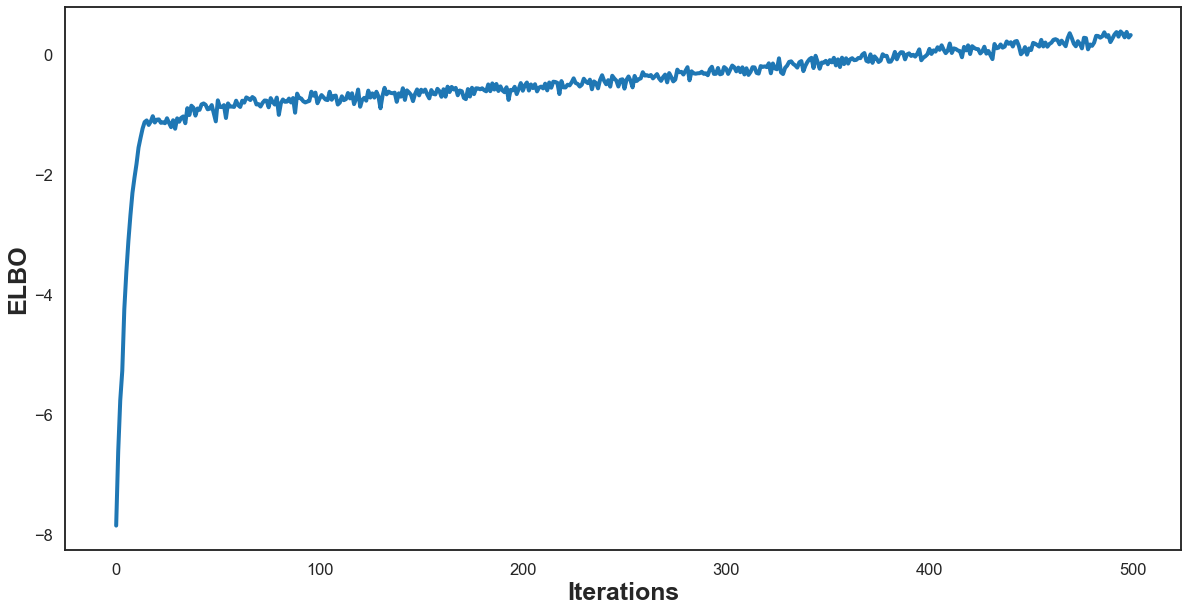

In [404]:
sns.set_context('talk')

elbo = bints.elbo_track
elbo = elbo.detach().numpy()
f,ax=plt.subplots(figsize=(20,10))

ax.set_ylabel('ELBO',fontsize=25,fontweight='bold')

ax.set_xlabel('Iterations',fontsize=25,fontweight='bold')
#ax.set_yscale('log')
ax.plot(elbo[1:],linewidth=4)

### Visualize predicted likelihood

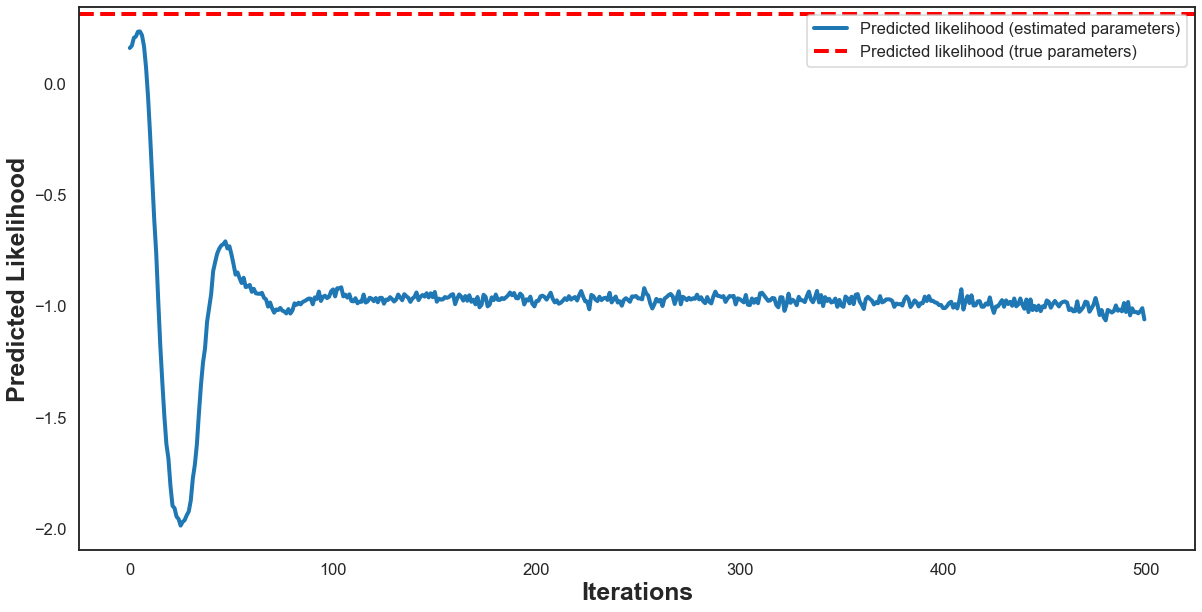

In [405]:
sns.set_context('talk')

pl = bints.predicted_likelihood_track
f,ax=plt.subplots(figsize=(20,10))

ax.set_ylabel('Predicted Likelihood',fontsize=25,fontweight='bold')

ax.set_xlabel('Iterations',fontsize=25,fontweight='bold')
ax.plot(pl[1:], label='Predicted likelihood (estimated parameters)',linewidth=4)
ax.axhline(y = bints.true_pred_log, c='red', linestyle='--', label='Predicted likelihood (true parameters)',linewidth=4)
ax.legend()

### Visualize error between estimated and true parameters

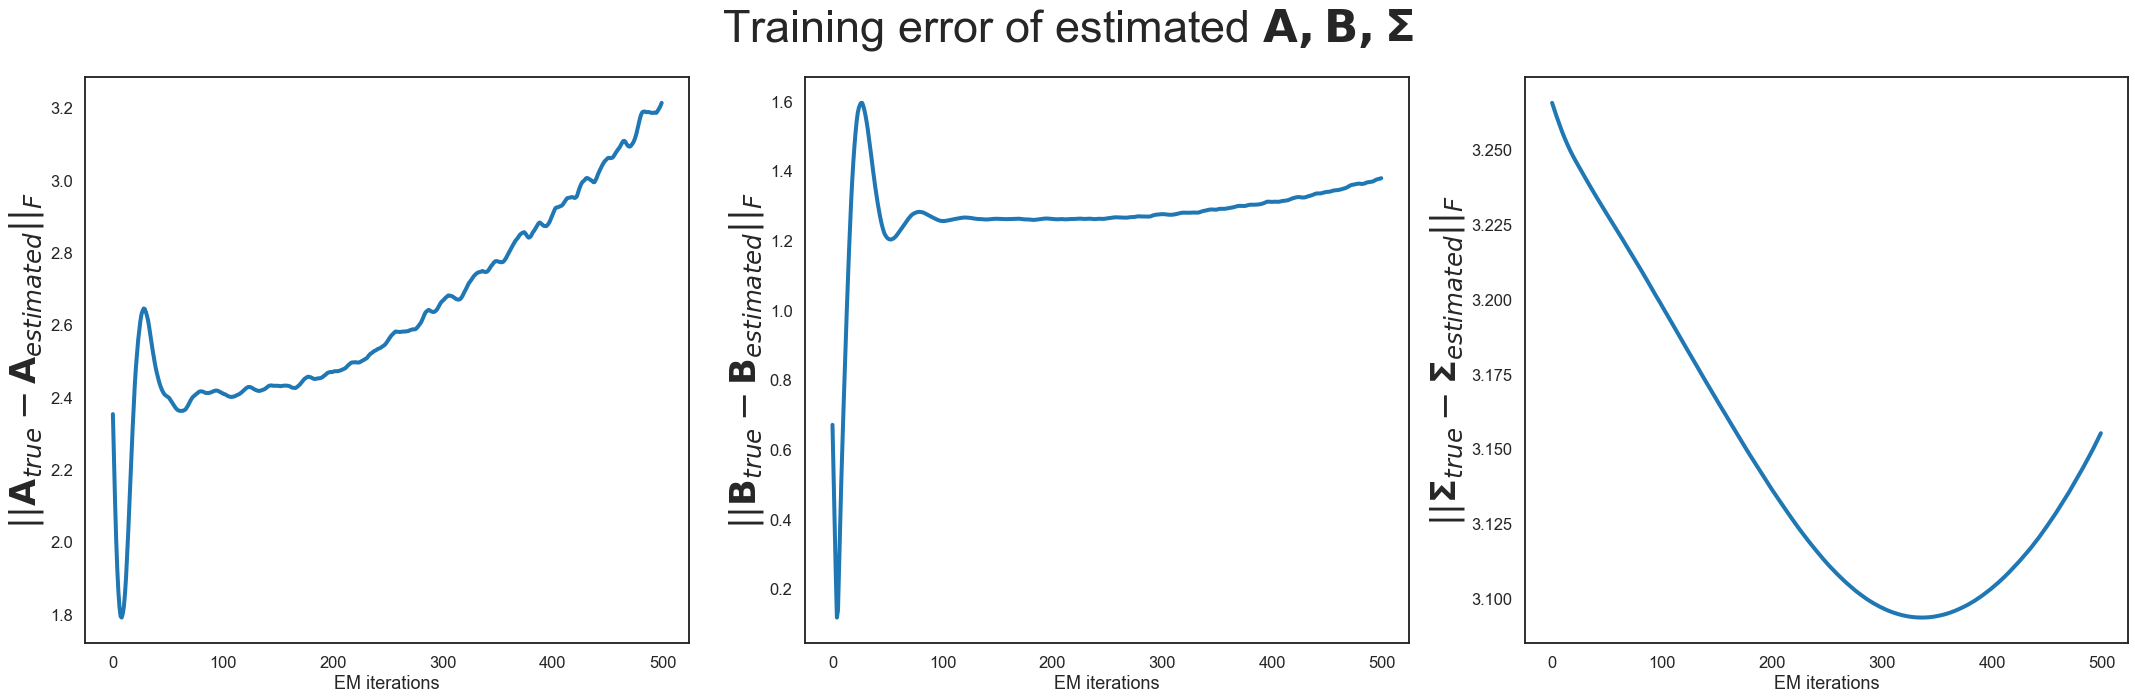

In [406]:
f,ax = plt.subplots(1,3,figsize=(30,10))


f.suptitle('Training error of estimated $\mathbf{A,B,\Sigma}$', fontsize=45)

ax[0].plot(bints.A_error_track[1:],linewidth=4)
ax[0].set_ylabel('$||\mathbf{A}_{true}-\mathbf{A}_{estimated}||_F$',fontsize=35)
ax[1].plot(bints.B_error_track[1:],linewidth=4)
ax[1].set_ylabel('$||\mathbf{B}_{true}-\mathbf{B}_{estimated}||_F$',fontsize=35)
ax[2].plot(bints.sigma_error_track[1:],linewidth=4)
ax[2].set_ylabel('$||\mathbf{\Sigma}_{true}-\mathbf{\Sigma}_{estimated}||_F$',fontsize=35)

for i in [0,1,2]: 
    
    ax[i].set_xlabel('EM iterations')
plt.tight_layout()

### Vizualise gradients 

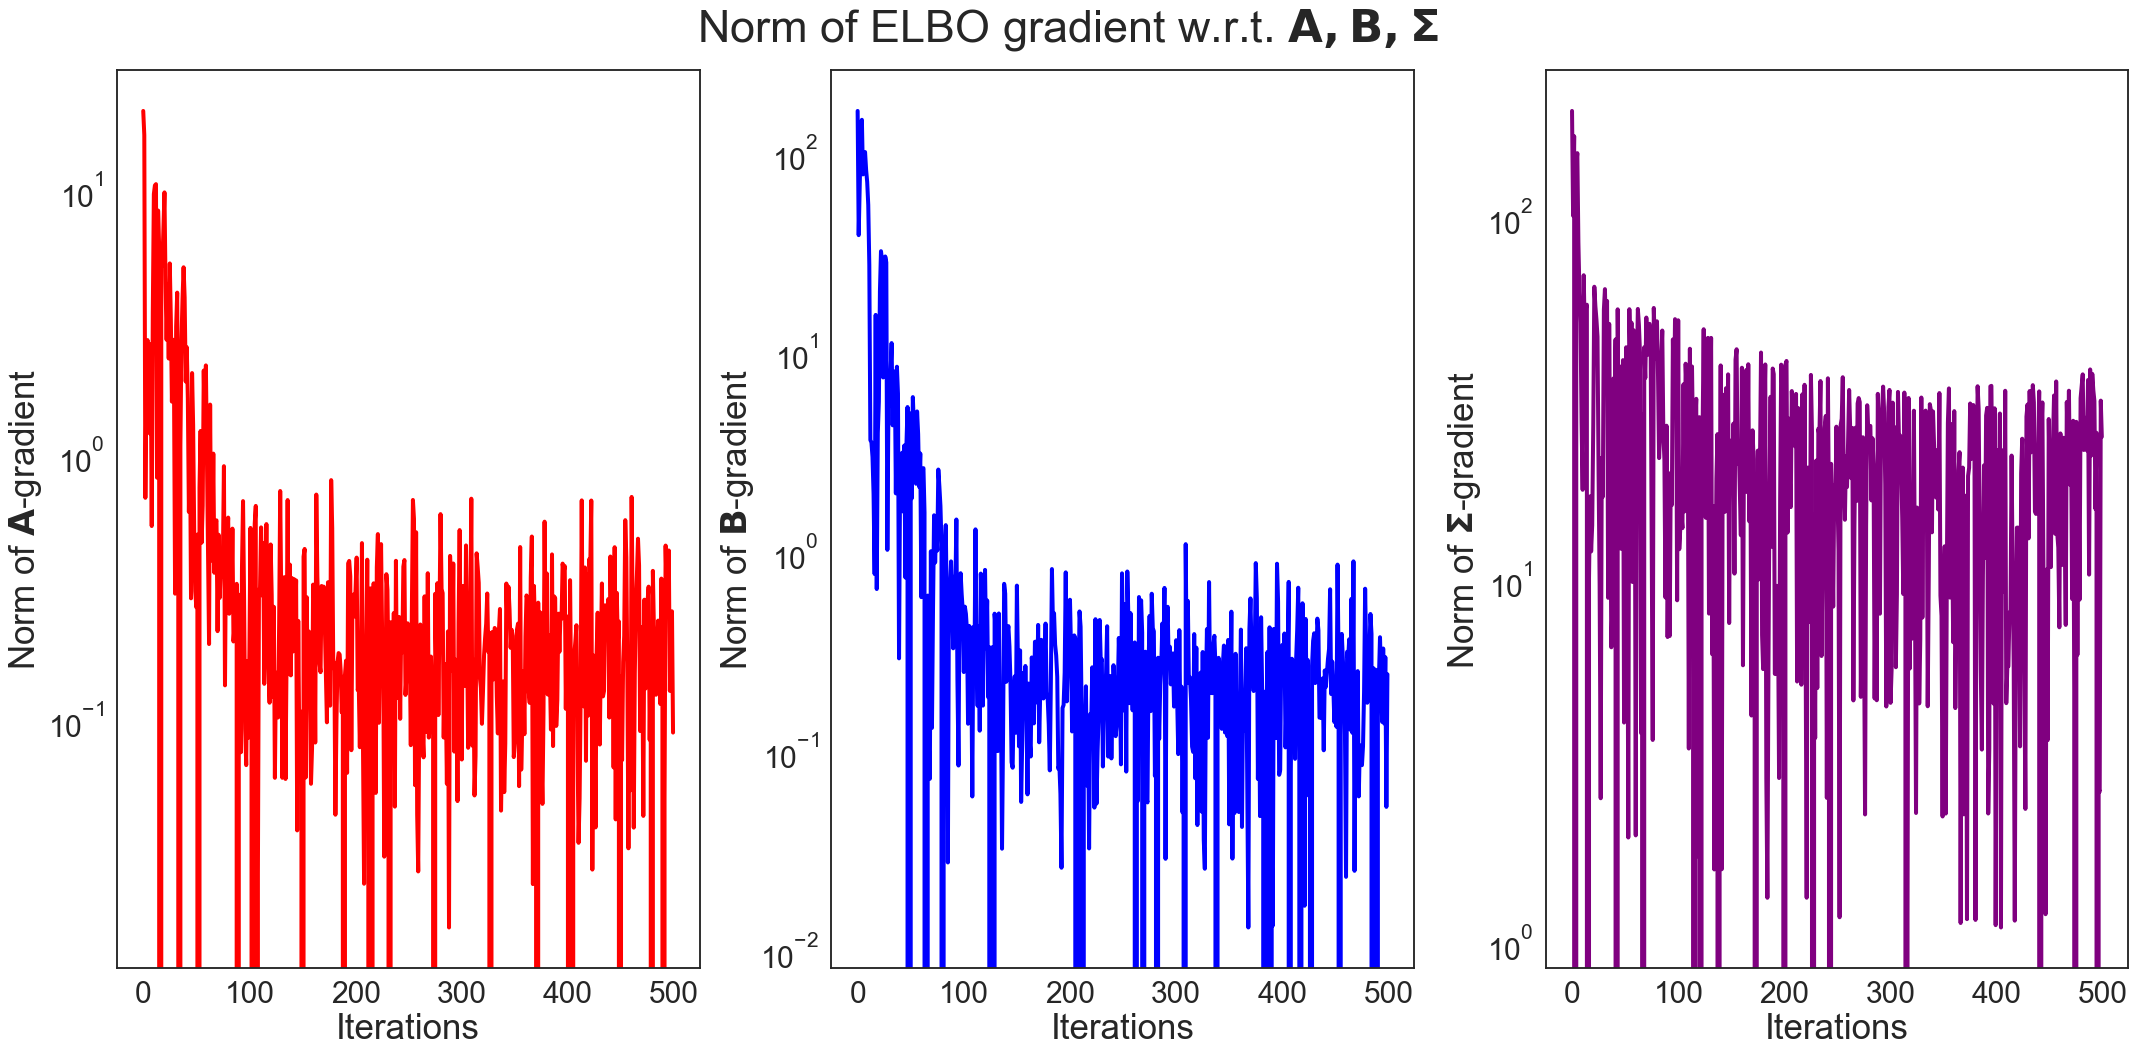

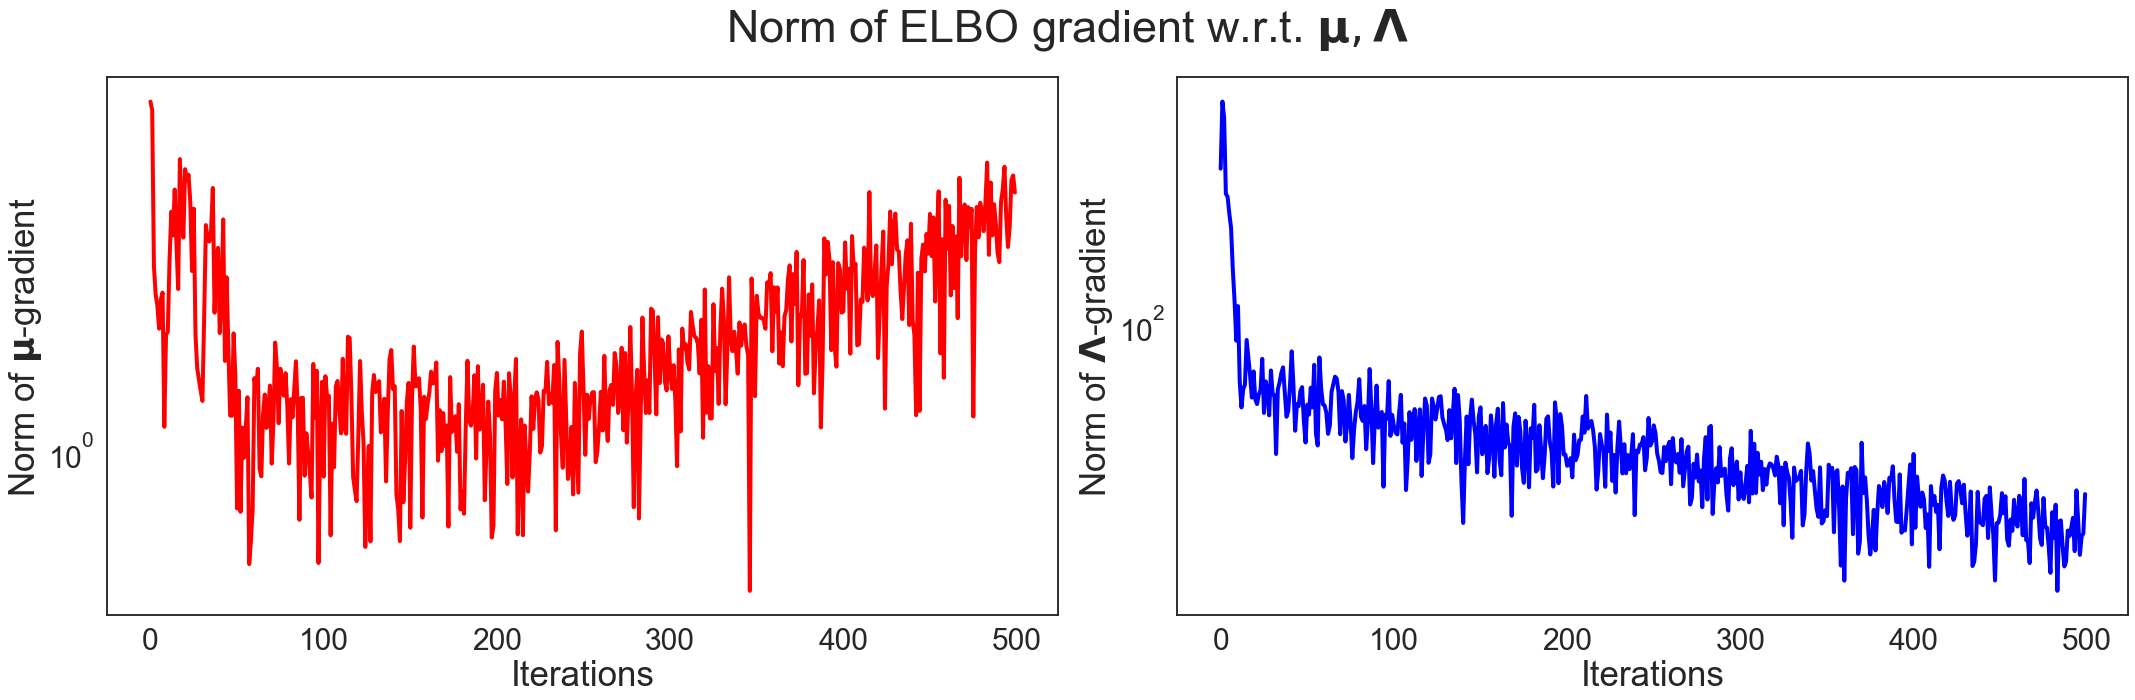

In [407]:
f,ax = plt.subplots(1,3,figsize=(30,15))


f.suptitle('Norm of ELBO gradient w.r.t. $\mathbf{A,B,\Sigma}$', fontsize=45)


ax[0].plot(bints.A_grad_track[1:],c='red',linewidth=4)
ax[0].set_ylabel('Norm of $\mathbf{A}$-gradient',fontsize=35)
ax[0].set_yscale('log')
ax[1].plot(bints.B_grad_track[1:],c='blue',linewidth=4)
ax[1].set_ylabel('Norm of $\mathbf{B}$-gradient',fontsize=35)
ax[1].set_yscale('log')
ax[2].plot(bints.sigma_grad_track[1:], c='purple',linewidth=4)
ax[2].set_ylabel('Norm of $\mathbf{\Sigma}$-gradient',fontsize=35)
ax[2].set_yscale('log')


for i in [0,1,2]: 
    ax[i].set_xlabel('Iterations',fontsize=35)
    ax[i].tick_params(axis='both', which='major', labelsize=30)

    
plt.tight_layout()
plt.show()

f,ax = plt.subplots(1,2,figsize=(30,10))

f.suptitle('Norm of ELBO gradient w.r.t. $\mathbf{\mu}, \mathbf{\Lambda}$', fontsize=45)


ax[0].plot(bints.mu_approx_grad_track[1:],c='red',linewidth=4)
ax[0].set_ylabel('Norm of $\mathbf{\mu}$-gradient',fontsize=35)
ax[0].set_yscale('log')
ax[1].plot(bints.var_approx_grad_track[1:],c='blue',linewidth=4)
ax[1].set_ylabel('Norm of $\mathbf{\Lambda}$-gradient',fontsize=35)
ax[1].set_yscale('log')

for i in [0,1]: 
    
    ax[i].set_xlabel('Iterations',fontsize=35)
    ax[i].tick_params(axis='both', which='major', labelsize=30)

    
plt.tight_layout()
plt.show()

### Vizualise evolution of $\mathbf{A}$

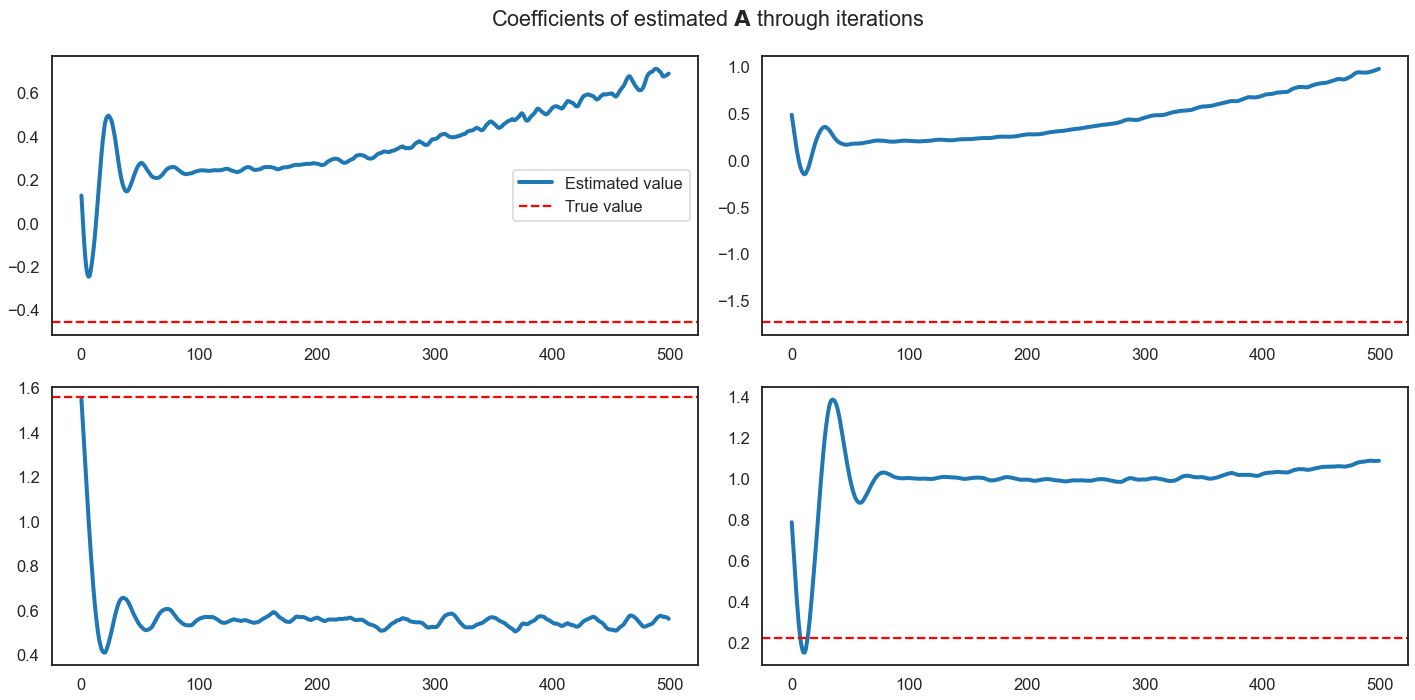

In [408]:
f,ax=plt.subplots(d,d,figsize=(20,10))
reshaped_A_track = bints.A_track.reshape(-1,d,d).detach().numpy()

f.suptitle('Coefficients of estimated $\mathbf{A}$ through iterations')


for i in np.arange(d): 
    for j in np.arange(d):
        ax[i,j].plot(reshaped_A_track[1:,i,j],label='Estimated value',linewidth=4)
        
        ax[i,j].axhline(y = bints.true_A[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
        
        
        
plt.tight_layout()

### Visualise evolution of $\mathbf{B}$

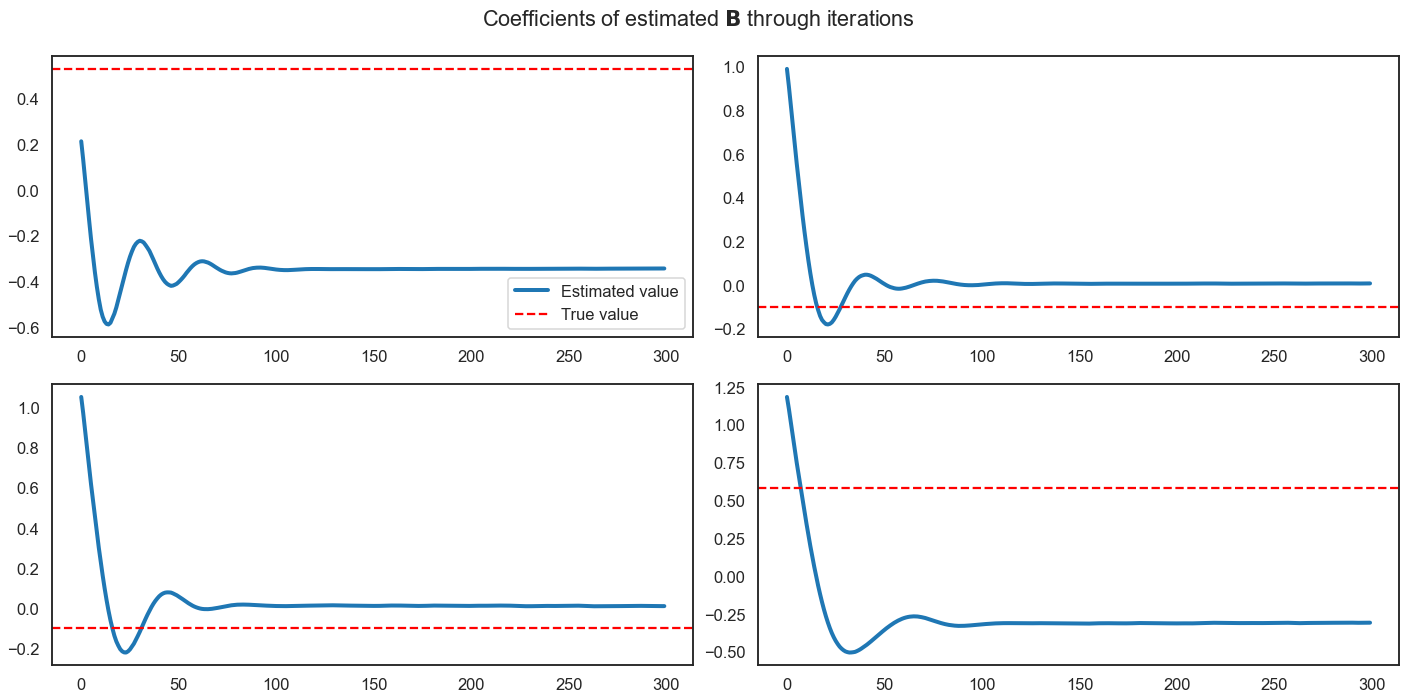

In [401]:
f,ax=plt.subplots(d,d,figsize=(20,10))
reshaped_B_track = bints.B_track.reshape(-1,d,d).detach().numpy()
f.suptitle('Coefficients of estimated $\mathbf{B}$ through iterations')


for i in np.arange(d): 
    for j in np.arange(d):
        
        ax[i,j].plot(reshaped_B_track[1:,i,j],label='Estimated value',linewidth=4)
        ax[i,j].axhline(y = bints.true_B[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
plt.tight_layout()


### Visualise evolution of $\mathbf{\Sigma}$

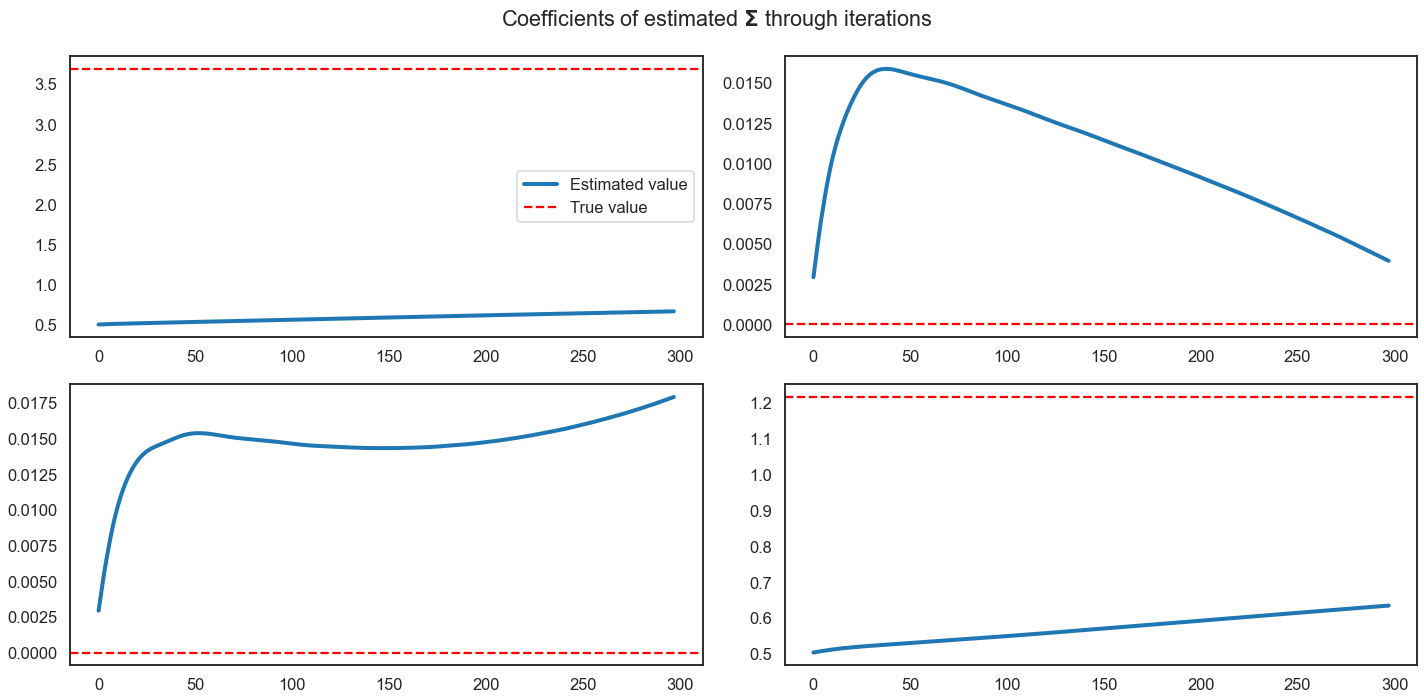

In [402]:
f,ax=plt.subplots(d,d,figsize=(20,10))
reshaped_sigma_track = bints.sigma_track.reshape(-1,d,d).detach().numpy()
f.suptitle('Coefficients of estimated $\mathbf{\Sigma}$ through iterations')

for i in np.arange(d): 
    
    for j in np.arange(d):
        
        ax[i,j].plot(reshaped_sigma_track[3:,i,j], label='Estimated value',linewidth=4)
        
        ax[i,j].axhline(y = bints.true_sigma[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
plt.tight_layout()


In [386]:
mu_track = bints.mu_approx_track

In [232]:
mu_track = mu_track.reshape(-1,d,T+1)

tensor([[0.4690, 0.6340, 0.7350, 0.8090, 0.8210],
        [0.4490, 0.3640, 0.2740, 0.2360, 0.1810]])


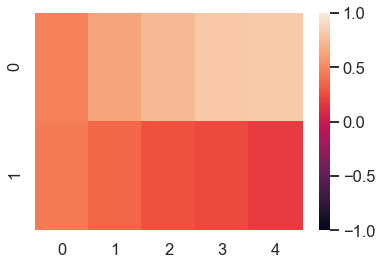

tensor([[0.3732, 0.7366, 0.8016, 0.8443, 0.9603],
        [0.2171, 0.2193, 0.2026, 0.2047, 0.1935]])


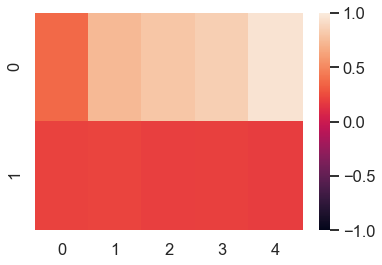

In [233]:
sns.heatmap(mu_track[1,:,:],vmin=-1,vmax=1)
print(mu_track[1,:,:])
plt.show()
sns.heatmap(mu_track[-1,:,:],vmin=-1,vmax=1)
print(mu_track[-1,:,:])

In [234]:
var_track = bints.var_approx_track

In [235]:
var_track = var_track[1:].reshape(-1,d,T+1,T+1)

RuntimeError: shape '[-1, 2, 5, 5]' is invalid for input of size 50025

In [254]:
for j in bints.mu_dic.keys():
    print(bints.mu_dic[j]["variable"].grad)

tensor(-903.0667)
tensor(-2933.4885)
tensor(-4028.5674)
tensor(-3228.3987)
tensor(0.)
tensor(-1582.8291)
tensor(-1834.5259)
tensor(-2057.0066)
tensor(-1080.0291)
tensor(28.8762)


In [180]:
(sum([(bints.mu_dic[key]["variable"].grad)**2 for key in bints.mu_dic.keys()]))**(1/2)

tensor(33.5727)

In [181]:
(sum([(bints.var_dic[key]["variable"].grad)**2 for key in bints.var_dic.keys()]))**(1/2)

tensor(13.7927)